In [17]:
from metats.pipeline import MetaLearning
from metats.features.unsupervised import DeepAutoEncoder
from metats.features.deep import AutoEncoder, LSTMDecoder, LSTMEncoder
from tensorflow.python.keras.models import load_model
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager

In [14]:
def Symmetric_mean_absolute_percentage_error(actual, predicted):
    total=len(actual)
    numerator=np.abs(actual-predicted)
    denominator=np.abs(actual)+np.abs(predicted)
    SMAPE=(100/total)*np.sum(numerator/denominator)
    
    return SMAPE

In [18]:
def vizualization(train_term,test_y,pred_y):
    font_path = "./NanumGothicBold.ttf"
    fontprop = font_manager.FontProperties(fname=font_path)
    
    plt.figure(figsize=(32, 16))
    plt.plot(np.arange(train_term), test_y[0:train_term], color='red', ls='-', lw=3, label='Raw Data')
    plt.plot(np.arange(train_term), pred_y[0:train_term], color='blue', ls='--', lw=3, label='Prediction')
    plt.xlabel('[Time]', fontsize=24, fontweight='bold')
    plt.ylabel('[PM10]', fontsize=24, fontweight='bold')
    plt.title('Predict',fontsize=30, weight='bold',fontproperties=fontprop)
    plt.xticks( fontsize=15, fontweight='bold')
    plt.yticks( fontsize=15, fontweight='bold')
    plt.grid(True)
    return

## 기존에 fit한 메타러너 load, 성능 평가

In [2]:
pipeline = MetaLearning(method='averaging', loss='mse')

# Feature Extractor 설정
enc = LSTMEncoder(input_size=4, latent_size=4,
    hidden_size=16, num_layers=24, directions=1)
dec = LSTMDecoder(output_length=1, output_size=1,
    latent_size=4, hidden_size=16, num_layers=2, directions=1)

ae = AutoEncoder(encoder=enc, decoder=dec)
ae_features = DeepAutoEncoder(auto_encoder=ae, epochs=70, verbose=False)

pipeline.add_feature(ae_features)

# Base Forecaster 설정, pipeline 추가
forecaster1  = load_model('../Model_Training/Saved_Model/LSTM(Early_Stopping).pt')
forecaster2 = load_model('../Model_Training/Saved_Model/Attention_LSTM(Early_Stopping).pt')
forecaster3 = load_model('../Model_Training/Saved_Model/Dual_Attention_LSTM(Early_Stopping).pt')

pipeline.add_forecaster(forecaster1)
pipeline.add_forecaster(forecaster2)
pipeline.add_forecaster(forecaster3)

#MetaLearner 설정
learner=joblib.load("./MetaLearner.pkl")
pipeline.add_metalearner(learner)


## 테스트 적용할 데이터 load(예시)

In [8]:
address="../Grouped_Data/air_indoor_초등학교/Seasonal_Trend/ICW0W2000024.csv"

In [10]:
##병합한 데이터를 기준으로 학습한 Scaler를 사용합니다.
scaler1=joblib.load("../Merged_Data/Scaler/in_pm10_min.pkl")
scaler2=joblib.load("../Merged_Data/Scaler/in_pm10_max.pkl")
scaler3=joblib.load("../Merged_Data/Scaler/in_voc_min.pkl")
scaler4=joblib.load("../Merged_Data/Scaler/in_pm10_Seasonal_Trend.pkl")
scaler5=joblib.load("../Merged_Data/Scaler/Y_pm10.pkl")


##Scaler를 적용하고 pipeline에 입력되는 형태로 데이터를 변환합니다.
def data_load(address,scaler1,scaler2,scaler3,scaler4,scaler5):
    df1 = pd.read_csv(address).drop("time",axis=1)
    length=int(0.1*len(df1))
    df1=df1[:length]
    
    df1["in_pm10_min"]=scaler1.transform(np.array(df1["in_pm10_min"]).reshape(-1,1))
    df1["in_pm10_max"]=scaler2.transform(np.array(df1["in_pm10_max"]).reshape(-1,1))
    df1["in_voc_min"]=scaler3.transform(np.array(df1["in_voc_min"]).reshape(-1,1))
    df1["in_pm10_Seasonal_Trend"]=scaler4.transform(np.array(df1["in_pm10_Seasonal_Trend"]).reshape(-1,1))
    df1["Y_pm10"]=scaler5.transform(np.array(df1["Y_pm10"]).reshape(-1,1))
    
    df2=df1["Y_pm10"]
    
    time_series_x = df1.drop("Y_pm10",axis=1).values
    time_series_y = df2.values
    
    dataX = []
    dataY = []
    
    for i in range(0, len(time_series_x)-24):
        _x = time_series_x[i:i+24, :]
        _y = time_series_y[i+24-1]
        
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)

In [12]:
data_x,data_y=data_load(address,scaler1,scaler2,scaler3,scaler4,scaler5)

## predict 과정

In [13]:
pred_y=pipeline.predict(data_x,1)

##예측 결과를 Scaler로 inverse_transform합니다.
inv_data_y=scaler5.inverse_transform(np.array(data_y).reshape(-1,1))
inv_pred_y=scaler5.inverse_transform(pred_y[0])

In [15]:
## SMAPE를 기준으로 정확도를 계산합니다.
print("정확도(100-SMAPE) : {:f}".format(100-Symmetric_mean_absolute_percentage_error(inv_data_y,inv_pred_y)))

정확도(100-SMAPE) : 95.174779


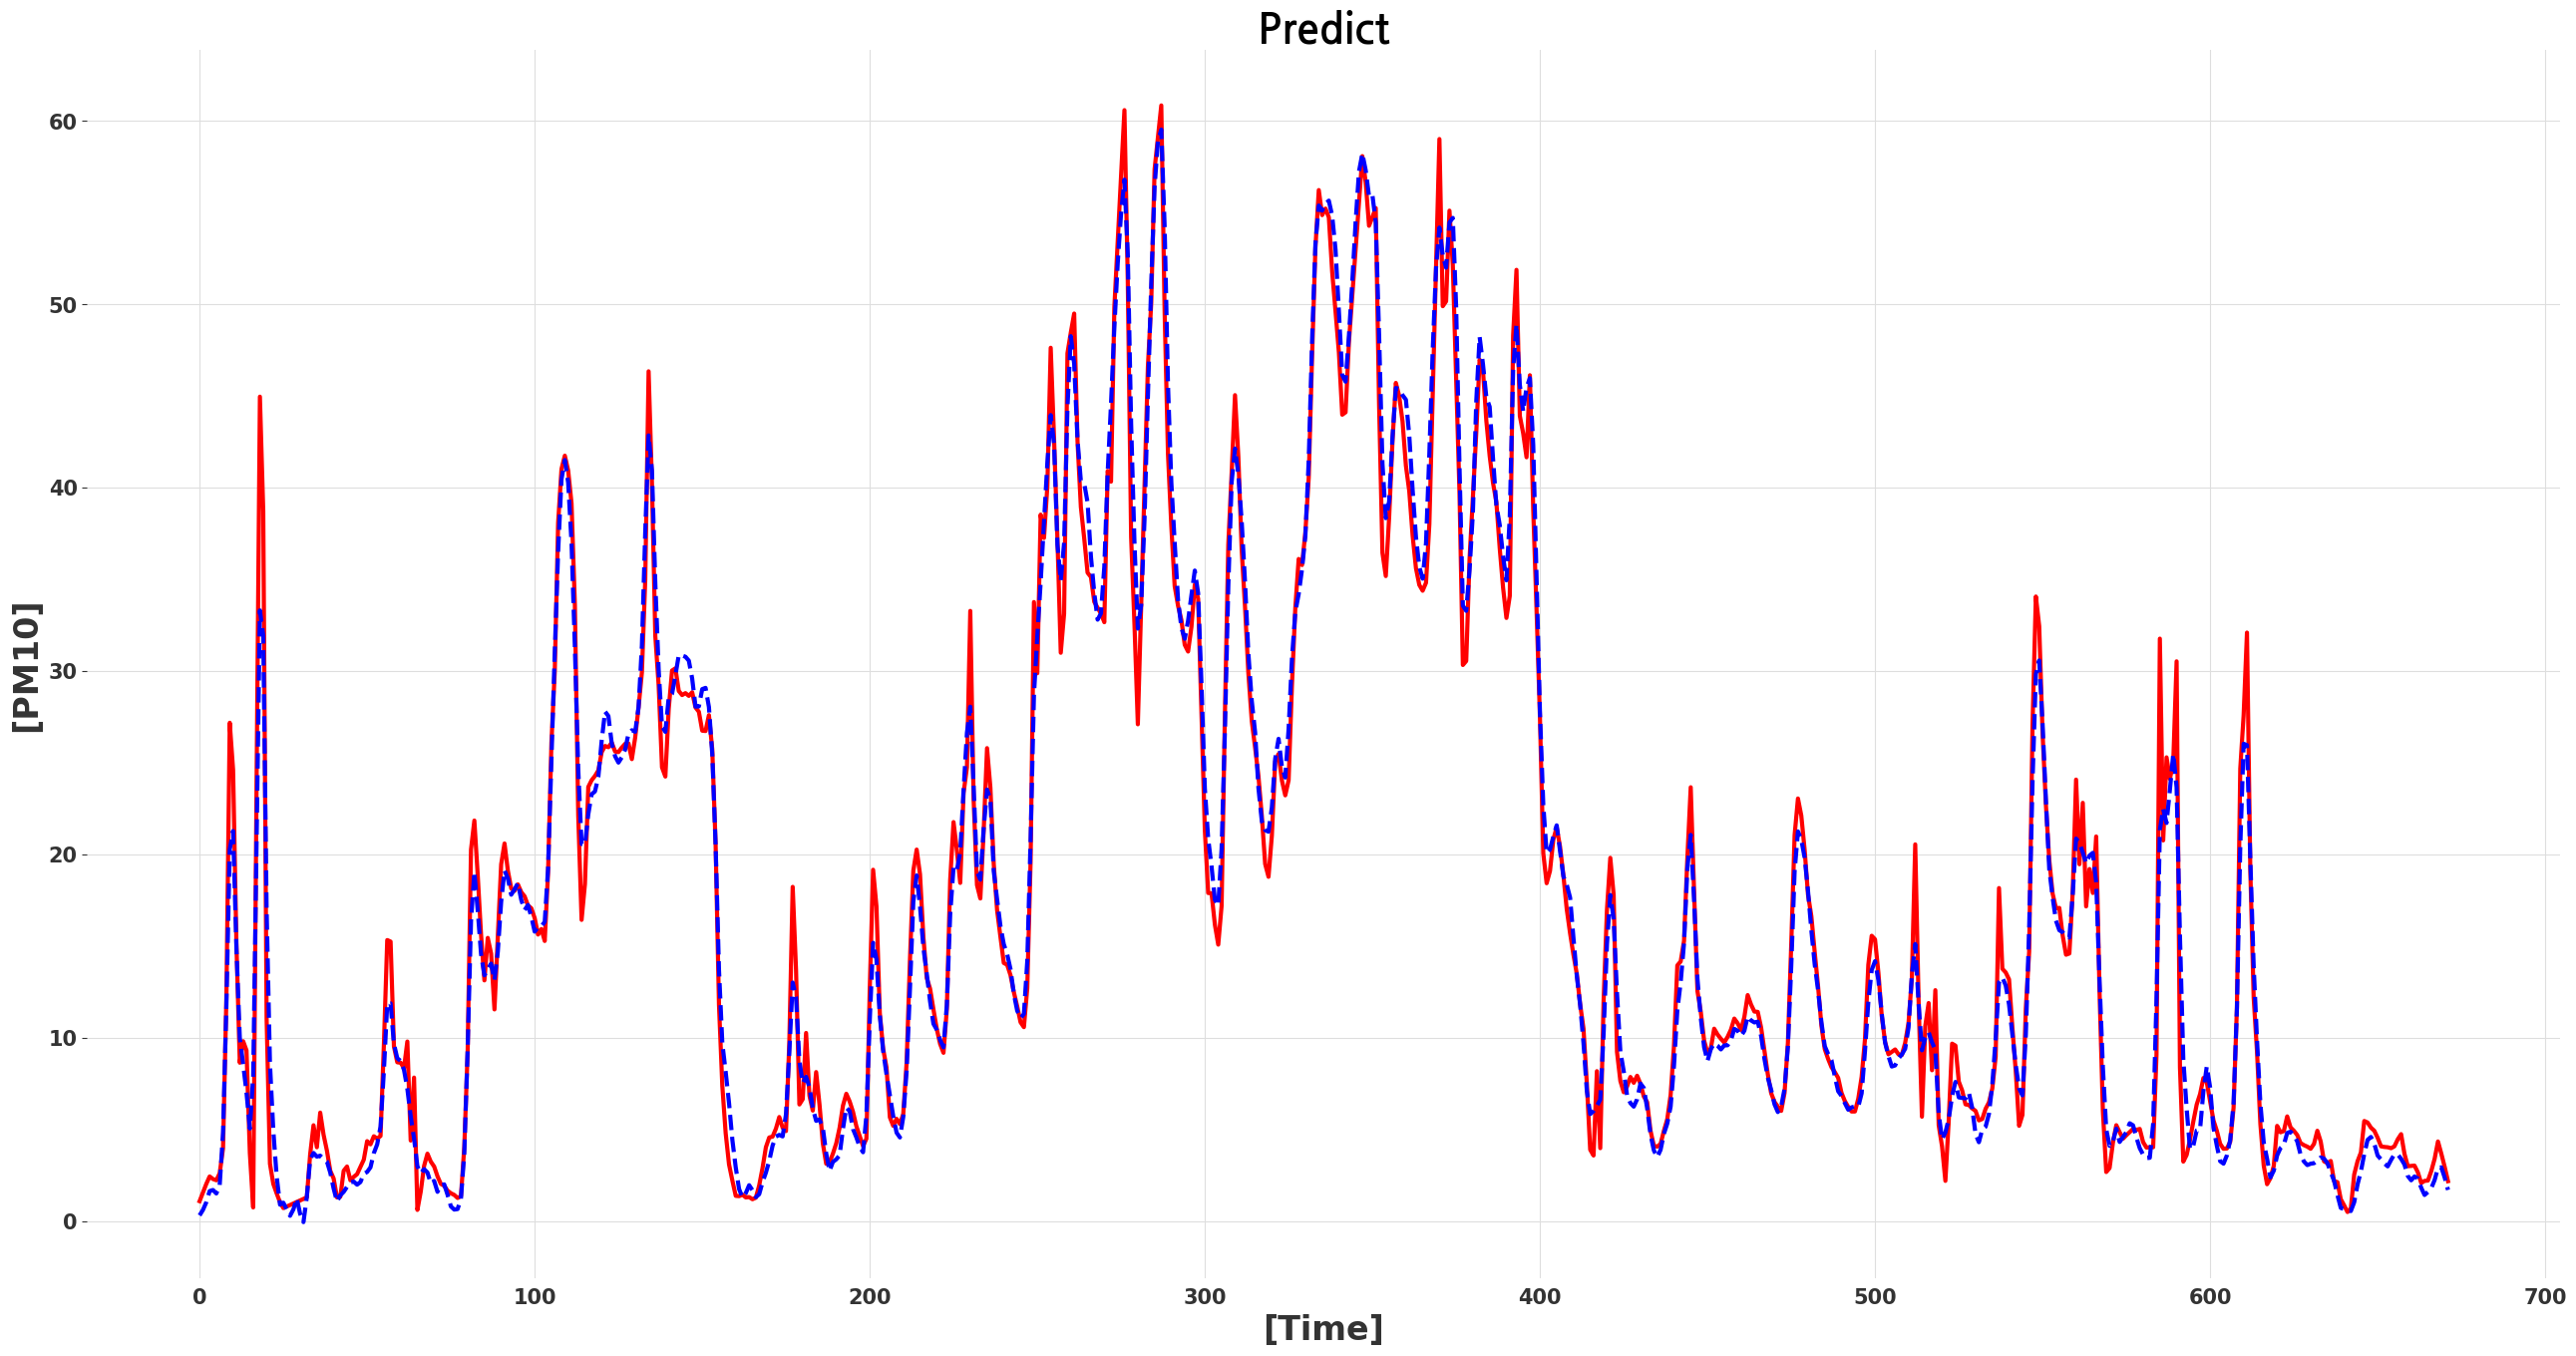

In [22]:
## 4주 동안(예시)의 예측 결과를 시각화 합니다.
vizualization(672,inv_data_y,inv_pred_y)